In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2, feature_causal_gan
from sparse_causal_model_learner_rl.trainable.discriminator import CausalFeatureActionModelDiscriminator
from sparse_causal_model_learner_rl.trainable.fcnet import FCNet

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
from functools import partial

In [72]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin',
                   '../sparse_causal_model_learner_rl/configs/server_collect.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1',
 'kc_dec',
 '5x5_1f1c1k_obs',
 'server_collect']

In [73]:
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.rl_multistep', [])
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.minibatch_size', 5000)
gin.bind_parameter('Config.n_collectors', 15)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [74]:
ray.init(ignore_reinit_error=True)

2021-02-10 01:53:19,344	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


In [75]:
gin.bind_parameter('CausalFeatureActionModelDiscriminator.input_embedder_cls',
                   {'f_t': partial(FCNet, hidden_sizes=[], activation_cls=None, add_input_batchnorm=True),
                    'f_t1': partial(FCNet, hidden_sizes=[], activation_cls=None, add_input_batchnorm=True)
                   })
gin.bind_parameter('CausalFeatureActionModelDiscriminator.feature_embedding_dim', 30)
gin.bind_parameter('CausalFeatureActionModelDiscriminator.aggregator_cls',
                   partial(FCNet, hidden_sizes=[256, 128, 64], activation_cls=torch.nn.Tanh,
                           add_input_batchnorm=True))
gin.bind_parameter('Config.causal_feature_action_model_discriminator', CausalFeatureActionModelDiscriminator)

In [76]:
# gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
# gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [77]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [78]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-10 01:53:19,537	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 5e1125f6-6b3a-11eb-8ff1-90e2baa1a248
Make environment KeyChest-v0 None {}


(pid=11370) Make environment KeyChest-v0 None {}
(pid=11362) Make environment KeyChest-v0 None {}
(pid=11326) Make environment KeyChest-v0 None {}
(pid=11364) Make environment KeyChest-v0 None {}
(pid=11317) Make environment KeyChest-v0 None {}
(pid=11339) Make environment KeyChest-v0 None {}
(pid=11345) Make environment KeyChest-v0 None {}
(pid=11390) Make environment KeyChest-v0 None {}
(pid=11298) Make environment KeyChest-v0 None {}
(pid=11351) Make environment KeyChest-v0 None {}
(pid=11311) Make environment KeyChest-v0 None {}
(pid=11393) Make environment KeyChest-v0 None {}
(pid=11332) Make environment KeyChest-v0 None {}
(pid=11366) Make environment KeyChest-v0 None {}
(pid=11327) Make environment KeyChest-v0 None {}



In [79]:
learner.create_trainables()

In [80]:
learner.causal_feature_action_model_discriminator

CausalFeatureActionModelDiscriminator(
  (model_f_t): FCNet(
    (fc01): Linear(in_features=30, out_features=30, bias=True)
    (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_f_t1): FCNet(
    (fc01): Linear(in_features=32, out_features=30, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_a_t): IdentityNet()
  (agg): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (aggregator): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bia

In [81]:
learner.model

ManyNetworkCombinedModel(
  (bn): BatchNorm1d(34, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [82]:
learner.decoder

ModelDecoder(
  (model): FCNet(
    (fc01): Linear(in_features=847, out_features=512, bias=True)
    (fc02): Linear(in_features=512, out_features=30, bias=True)
  )
)

In [83]:
env = learner.env

In [84]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [85]:
ctx = learner.collect_and_get_context()

In [86]:
feature_causal_gan(**ctx, loss_type='generator')

{'loss': tensor(1.4565, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.6896636486053467,
  'loss_env_permuted': 0.6979010105133057,
  'loss_model': 0.6896544694900513,
  'mean_logits_env': 0.008223792538046837,
  'mean_logits_env_permuted': 0.008320028893649578,
  'mean_logits_model': 0.008344730362296104,
  'mse_model_pred': 2.6063358783721924}}

In [87]:
feature_causal_gan(**ctx, loss_type='discriminator')

{'loss': tensor(1.4572, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.6896636486053467,
  'loss_env_permuted': 0.6976892352104187,
  'loss_model': 0.6979991793632507,
  'mean_logits_env': 0.008223792538046837,
  'mean_logits_env_permuted': 0.007894471287727356,
  'mean_logits_model': 0.008344730362296104,
  'mse_model_pred': 2.6063358783721924}}

In [88]:
features = learner.decoder(ctx['obs'])

In [89]:
f = features.detach().cpu().numpy()

In [90]:
f.shape

(5000, 30)

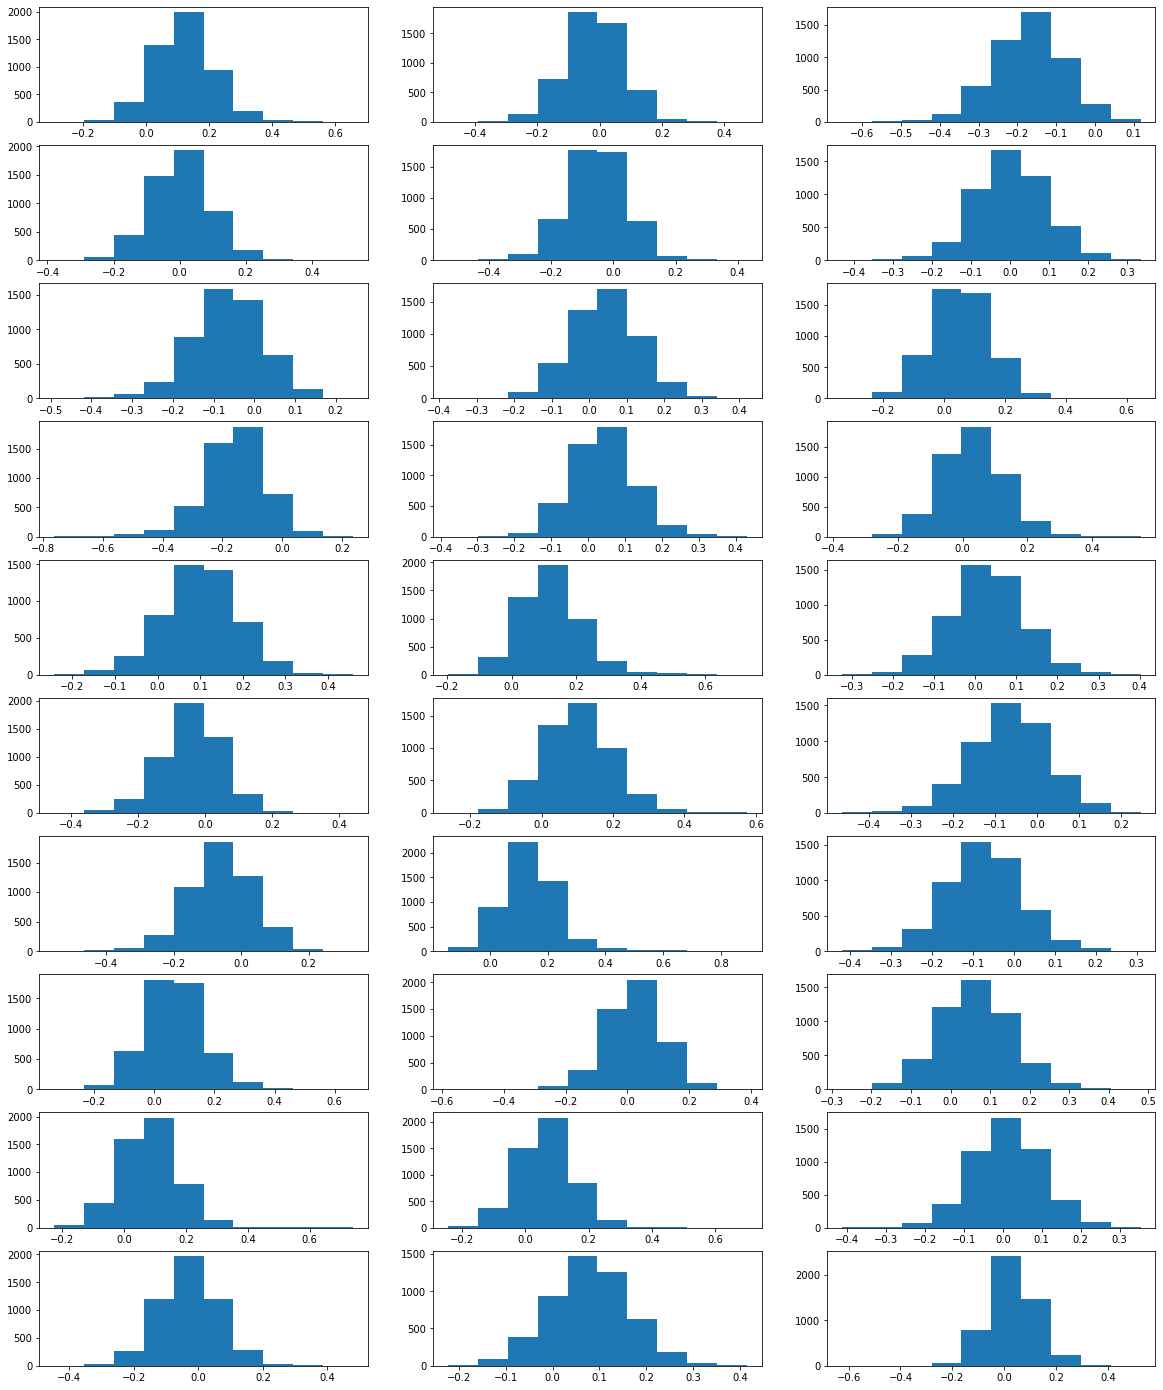

In [91]:
plt.figure(figsize=(20, 25))
for i_f in range(f.shape[1]):
    plt.subplot(10, 3, i_f + 1)
    plt.hist(f[:, i_f])

In [92]:
pd.DataFrame(f).std()

0     0.097186
1     0.093818
2     0.093019
3     0.093178
4     0.096343
5     0.090967
6     0.088978
7     0.089718
8     0.098907
9     0.105764
10    0.086922
11    0.098155
12    0.088672
13    0.098693
14    0.089186
15    0.092277
16    0.097961
17    0.092801
18    0.095384
19    0.100843
20    0.093259
21    0.098145
22    0.090647
23    0.092555
24    0.091848
25    0.086979
26    0.090834
27    0.092742
28    0.086037
29    0.090576
dtype: float32

<AxesSubplot:>

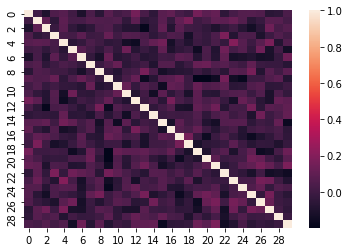

In [93]:
sns.heatmap(pd.DataFrame(f).corr())

In [94]:
env.engine.return_rgb = False

In [95]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.Tanh)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', False)

In [96]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [97]:
learner.causal_feature_action_model_discriminator.__init__(observation_shape=learner.observation_shape,
                                                           action_shape=learner.action_shape,
                                                           total_feature_shape=learner.model_kwargs['total_feature_shape'],
                         feature_shape=learner.feature_shape)
learner.causal_feature_action_model_discriminator = learner.causal_feature_action_model_discriminator.cuda()

In [98]:
learner.causal_feature_action_model_discriminator

CausalFeatureActionModelDiscriminator(
  (model_f_t): FCNet(
    (fc01): Linear(in_features=30, out_features=30, bias=True)
    (bn): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_f_t1): FCNet(
    (fc01): Linear(in_features=32, out_features=30, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (model_a_t): IdentityNet()
  (agg): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bias=True)
    (fc04): Linear(in_features=64, out_features=1, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (aggregator): FCNet(
    (fc01): Linear(in_features=64, out_features=256, bias=True)
    (fc02): Linear(in_features=256, out_features=128, bias=True)
    (fc03): Linear(in_features=128, out_features=64, bia

In [99]:
learner.non_sparse_model.model.model.activation

[Tanh(), Tanh(), Tanh(), None]

In [100]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [101]:
learner.non_sparse_model.model.enable_switch

False

In [102]:
mins = None
maxes = None

In [103]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [104]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [105]:
from sparse_causal_model_learner_rl.loss.helpers import gather_additional_features


In [106]:
@gin.configurable
def info_nce(obs_x, action_x, obs_y, model, decoder,
             additional_feature_keys,
             causal_feature_action_model_discriminator,
             obs_delta_eps=1e-3,
             **kwargs):
    batch_dim = len(obs_x)
    device = obs_x.device

    # input features
    f_x = decoder(obs_x)

    # output features
    f_y = decoder(obs_y)
    f_y_add = gather_additional_features(additional_feature_keys=additional_feature_keys, **kwargs)
    f_y_all = torch.cat([f_y, f_y_add], dim=1)

    # permuted output features
    idxes = torch.randperm(batch_dim, device=device)
    f_y_all_permuted = f_y_all[idxes]
    obs_y_permuted = obs_y[idxes]
    act_permuted = action_x[idxes]
    
#     f_y_pred = model(f_t=f_x, a_t=action_x, all=True)
#     f_y_pred_permuted = f_y_pred[idxes]

    logits_environment = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_all)
    logits_permuted = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_all_permuted)
#     logits_model = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_pred)
#     logits_model_permuted = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_pred_permuted)

    # want -log (p_true[i] / p_true[i] + p_permuted[i]) -> min

    env_permuted_obs_close = ((obs_y_permuted - obs_y).flatten(start_dim=1).pow(2).sum(1) +
                              (act_permuted - action_x).flatten(start_dim=1).pow(2).sum(1) <=
                              obs_delta_eps).to(device).detach()
    
    p_env = torch.nn.Sigmoid()(logits_environment)
    p_permuted = torch.nn.Sigmoid()(logits_permuted)
#     p_model = torch.nn.Sigmoid()(logits_model)
#     p_model_permuted = torch.nn.Sigmoid()(logits_model_permuted)
    
    loss_vect = -torch.log(p_env / (p_env + p_permuted ))    
    loss_vect = torch.where(env_permuted_obs_close, torch.zeros_like(loss_vect), loss_vect)
    loss_emb = loss_vect.mean()
    
#     loss_vect = -torch.log(p_model / (p_model + p_permuted + p_model_permuted))    
#     loss_vect = torch.where(env_permuted_obs_close, torch.zeros_like(loss_vect), loss_vect)
#     loss_model = loss_vect.mean()
    
    loss = loss_emb #+ loss_model
    
    return {'loss': loss,
            'metrics': {'loss_emb': loss_emb.item(),}}
#                        'loss_model': loss_model.item()}}

In [107]:
@gin.configurable
def feature_causal_gan(obs_x, action_x, obs_y, model, decoder,
                       additional_feature_keys,
                       causal_feature_action_model_discriminator,
                       obs_delta_eps=1e-3,
                       add_mse_coeff=None,
                       loss_type=None,
                       **kwargs):
    """GAN loss where the discriminator classifies correct/incorrect causal pairs."""
    assert loss_type in ['generator', 'discriminator', 'only_contrastive'], f"Wrong loss type {loss_type}"
    batch_dim = len(obs_x)
    device = obs_x.device

    # input features
    f_x = decoder(obs_x)

    # output features
    f_y = decoder(obs_y)
    f_y_add = gather_additional_features(additional_feature_keys=additional_feature_keys, **kwargs)
    f_y_all = torch.cat([f_y, f_y_add], dim=1)

    # permuted output features
    idxes = torch.randperm(batch_dim, device=device)
    f_y_all_permuted = f_y_all[idxes]
    obs_y_permuted = obs_y[idxes]
    act_permuted = action_x[idxes]

    # predicted features
    if loss_type == 'discriminator':
        # do not allow the decoder to break the model
        # rather, the discriminator must find issues with the model itself.
        f_x_feed = f_x.detach()
    else:
        f_x_feed = f_x
    f_y_pred = model(f_t=f_x_feed, a_t=action_x, all=True)

    logits_environment = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_all)
    logits_model = causal_feature_action_model_discriminator(f_t=f_x_feed, a_t=action_x, f_t1=f_y_pred)
    logits_permuted = causal_feature_action_model_discriminator(f_t=f_x, a_t=action_x, f_t1=f_y_all_permuted)

    # prediction = 1 -> correct pair
    # prediction = 0 -> incorrect pair
    env_permuted_obs_close = ((obs_y_permuted - obs_y).flatten(start_dim=1).pow(2).sum(1) +
                              (act_permuted - action_x).flatten(start_dim=1).pow(2).sum(1) <=
                              obs_delta_eps).to(device).to(torch.float32).detach()
    ans_env = torch.ones((batch_dim,), device=device, dtype=torch.float32)
    ans_env_permuted = env_permuted_obs_close  # act+obs close -> same features -> must output 1, otherwise 0

    if loss_type == 'generator':  # generator wants to have all correct pairs
        ans_model = torch.ones((batch_dim,), device=device, dtype=torch.float32)
    elif loss_type == 'discriminator':  # discriminator must see issues with the generator
        ans_model = torch.zeros((batch_dim,), device=device, dtype=torch.float32)
    elif loss_type == 'only_contrastive':
        ans_model = None
    else:
        raise ValueError(f"Wrong loss_type: {loss_type}")

    criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')

    loss_env = criterion(logits_environment.view(-1), ans_env)
    loss_env_permuted = criterion(logits_permuted.view(-1), ans_env_permuted)
    if loss_type == 'only_contrastive':
        loss_model = torch.zeros(1)
    else:
        loss_model = criterion(logits_model.view(-1), ans_model)

    mse_model_pred = (f_y_pred - f_y_all).pow(2).sum(1).mean()
    
    if loss_type == 'generator' and add_mse_coeff is not None:
        loss_model = loss_model + add_mse_coeff * mse_model_pred
        
    if loss_type == 'only_contrastive':
        loss = loss_env + loss_env_permuted
    elif loss_type == 'generator':
        loss = loss_model / 10 + loss_env + loss_env_permuted
    elif loss_type == 'discriminator':
        loss = loss_model / 10 + loss_env + loss_env_permuted 

    metrics = {
        'loss_env': loss_env.item(),
        'loss_env_permuted': loss_env_permuted.item(),
        'loss_model': loss_model.item(),
        'mean_logits_env': logits_environment.mean().item(),
        'mean_logits_env_permuted': logits_permuted.mean().item(),
        'mean_logits_model': logits_model.mean().item(),
        'mse_model_pred': mse_model_pred.item(),
    }

    return {'loss': loss,
            'metrics': metrics}

In [108]:
metrics = []
losses_gen = []
losses_disc = []
losses_dec = []
ratios = []
ctx_set = False

In [109]:
use_model = learner.non_sparse_model
#use_model = AdhocWorldModel().cuda()

In [110]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512, 256])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [111]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [112]:
opt_disc = torch.optim.Adam(lr=1e-3, params=list(learner.causal_feature_action_model_discriminator.parameters()),# + list(learner.decoder.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )
opt_gen = torch.optim.Adam(lr=1e-3, params=list(use_model.parameters()), #list(learner.decoder.parameters()) + 
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )
opt_dec = torch.optim.Adam(lr=1e-3, params=list(learner.decoder.parameters()) + list(use_model.parameters()) + list(learner.causal_feature_action_model_discriminator.parameters()),
                      #amsgrad=True,
                       betas=(0.5, 0.8)
                      )

In [113]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(2.7049e-05, device='cuda:0'),
 tensor(0.0004, device='cuda:0'),
 tensor(2.8917e-05, device='cuda:0'),
 tensor(0.0013, device='cuda:0'),
 tensor(-0.0003, device='cuda:0'),
 tensor(-0.0125, device='cuda:0')]

In [114]:
feature_causal_gan(**ctx, loss_type='generator')

{'loss': tensor(1.4549, device='cuda:0', grad_fn=<AddBackward0>),
 'metrics': {'loss_env': 0.6362125873565674,
  'loss_env_permuted': 0.7551161646842957,
  'loss_model': 0.6361591815948486,
  'mean_logits_env': 0.11872519552707672,
  'mean_logits_env_permuted': 0.11888427287340164,
  'mean_logits_model': 0.11852196604013443,
  'mse_model_pred': 2.240255355834961}}

In [115]:
epochs = 500000
with tqdm(total=epochs) as pbar:
    for i in range(epochs):
        if i % 1 == 0 or not ctx_set:
            ctx_set = True
            ctx = learner.collect_and_get_context()
            ratio = ctx.get('context_stats_collected_sampled_ratio', None)
            if ratio:
                ratios.append(ratio)
            elif ratios:
                ratios.append(ratios[-1])
#             pbar.update(1)
#             continue

        ctx['non_sparse_model_add'] = use_model
                
#         def get_loss_obj(loss_type):
#             l_obj_fit = context_rewriter(function=feature_causal_gan, rewrite={'model': 'non_sparse_model_add'},
#                                          **ctx,
#                                          loss_type=loss_type,
#                                          add_mse_coeff=1.0)
#             return l_obj_fit
        
        
#         l_obj_disc = get_loss_obj('discriminator')
#         l_obj_gen = get_loss_obj('generator')
#         l_obj_dec = get_loss_obj('only_contrastive')

#         stage = (i // 50) % 3
#         if stage == 0:
#             # contrastive loss training
#             loss = l_obj_dec['loss']
            
#             opt_dec.zero_grad()
#             loss.backward()
#             opt_dec.step()
#         elif stage == 2:
#             # discriminator training
            
#             loss = l_obj_disc['loss']
            
#             opt_disc.zero_grad()
#             loss.backward()
#             opt_disc.step()
#         elif stage == 1:
#             # generator training
#             loss = l_obj_gen['loss']
            
#             opt_gen.zero_grad()
#             loss.backward()
#             opt_gen.step()

        l_obj = context_rewriter(function=info_nce, rewrite={'model': 'non_sparse_model_add'}, **ctx)
        l_obj_fit = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model_add'}, **ctx)
        
        loss = l_obj['loss'] + l_obj_fit['loss']
    
#         losses_gen.append(l_obj_gen['loss'].item())
#         losses_disc.append(l_obj_disc['loss'].item())
#         losses_dec.append(l_obj_dec['loss'].item())
        losses_dec.append(l_obj['loss'].item())
#         losses_gen.append(l_obj['metrics']['loss_model'])
    
        opt_dec.zero_grad()
        loss.backward()
        opt_dec.step()
    
        m = {}
#         m.update(l_obj_disc['metrics'])
        m['mse_model_pred'] = l_obj_fit['loss'].item()
        metrics.append(m)
        pbar.update(1)
        stage = 0
        pbar.set_postfix(loss_gen=0, loss_disc=0, stage=stage, loss_dec=losses_dec[-1],
                         mse=l_obj_fit['loss'].item())#metrics[-1]['mse_model_pred'])

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

/home/sergei/miniconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/home/sergei/miniconda3/envs/causal/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


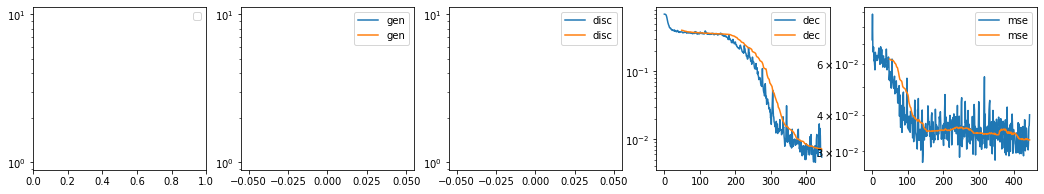

In [116]:
metrics_dct = lstdct2dctlst(metrics)

# gan
plt.figure(figsize=(18, 3))
plt.subplot(1, 5, 1)
# losses = np.array(losses_gen) + losses_disc
# plt.plot(losses, label='tot')
# plt.plot(pd.Series(losses).rolling(50).median(), label='tot')
plt.legend()
plt.yscale('log')

plt.subplot(1, 5, 2)
plt.plot(losses_gen, label='gen')
plt.plot(pd.Series(losses_gen).rolling(50).median(), label='gen')
plt.legend()
plt.yscale('log')
plt.subplot(1, 5, 3)
plt.plot(losses_disc, label='disc')
plt.plot(pd.Series(losses_disc).rolling(50).median(), label='disc')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

plt.subplot(1, 5, 4)
plt.plot(losses_dec, label='dec')
plt.plot(pd.Series(losses_dec).rolling(50).median(), label='dec')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

plt.subplot(1, 5, 5)
plt.plot(metrics_dct['mse_model_pred'], label='mse')
plt.plot(pd.Series(metrics_dct['mse_model_pred']).rolling(50).median(), label='mse')

plt.legend()
#plt.plot(dplus, label='dplus')
plt.yscale('log')

Text(0, 0.5, 'fit loss')

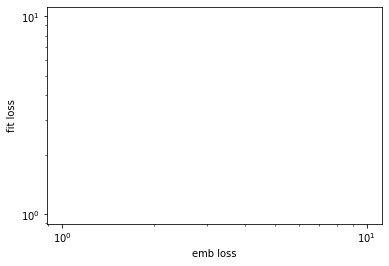

In [117]:
plt.scatter(losses_gen, losses_disc, alpha=0.05)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('emb loss')
plt.ylabel('fit loss')

In [118]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [119]:
%load_ext jupyternotify
%autonotify -a 30

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [120]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
# f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

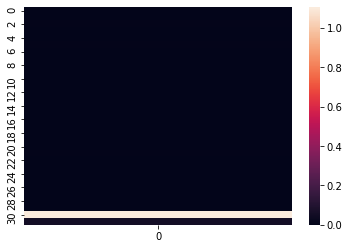

In [121]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1), vmin=0)

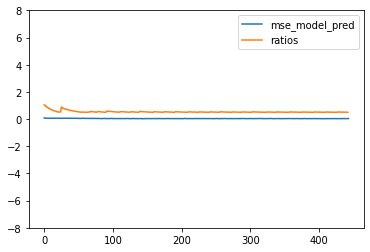

In [122]:
metrics_dct['ratios'] = ratios
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.ylim((-8, 8))
plt.legend()
plt.show()

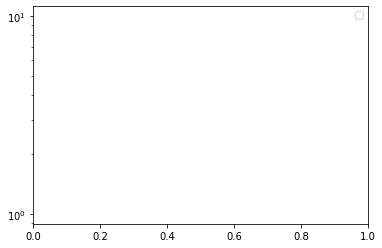

In [123]:
for key, vals in metrics_dct.items():
    if 'loss' not in key: continue
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key, alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()

In [124]:
plt.plot(metrics_dct['loss_model'])
plt.yscale('log')

KeyError: 'loss_model'

In [ ]:
learner.decoder(ctx['obs_x']).min()

<AxesSubplot:>

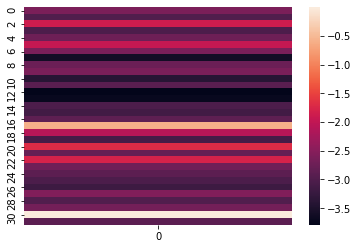

In [125]:
sns.heatmap(np.log(((f_t1_pred - f_t1).pow(2).mean(0) / f_t1.std(0).pow(2)).cpu().detach().numpy().reshape(-1, 1)))

<AxesSubplot:>

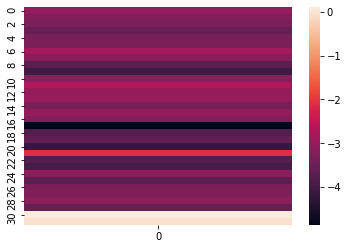

In [126]:
sns.heatmap(np.log(f_t1.std(0).pow(2).cpu().detach().numpy().reshape(-1, 1)))